**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer

# from keras.models import Model
# from keras. layers import Dense
# from keras. layers import Input

**Mounting files from google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/Network anomaly/UNSW_NB15_training-set.csv'
file_path2 = '/content/drive/My Drive/Colab Notebooks/Network anomaly/UNSW_NB15_testing-set.csv'

Mounted at /content/drive


**Loading dataset**

In [3]:
train_set = pd.read_csv(file_path)
test_set = pd.read_csv(file_path2)


**Grouping proto column as (TCP, UDP, ARP, OTHERS)**

In [ ]:
train_set['proto'] = train_set['proto'].apply(lambda x: x if x in ['tcp', 'udp', 'arp'] else 'others')
test_set['proto'] = test_set['proto'].apply(lambda x: x if x in ['tcp', 'udp', 'arp'] else 'others')
#train_set['proto'].value_counts()
test_set['proto'].value_counts()

,count
proto,
tcp,79951
udp,63283
others,29253
arp,2859


**Categorical and binary columns that will not be scaled**

In [4]:
categorical_cols =['id','proto', 'service', 'state', 'attack_cat', 'label','is_sm_ips_ports', 'is_ftp_login']

***Making both train and test datasets have same values in column (if not it will make error in encoding process) ***

In [5]:
test_set = test_set[
    ~(
        test_set['state'].isin(['URN', 'ECO', 'no', 'PAR'])
    )
]


Checking if we did correct

In [6]:
# For train_set
print("Train Set Unique Values:")
for col in ['proto', 'service', 'state']:
    print(f"{col} (train):", sorted(train_set[col].unique()))

print("\nTest Set Unique Values:")
# For test_set
for col in ['proto', 'service', 'state']:
    print(f"{col} (test):", sorted(test_set[col].unique()))


#['icmp', 'rtp'] proto field test set de var train'de yoxdu  icmp 15 (0 attack)  rtp 1 (0 attack)
#service is same
#{'URN', 'ECO', 'no', 'PAR'} for state    URN 1 (0 attack) ; ECO 12(0 attack) ; no 1 (0); PAR 1 (0 attack)
#train_set['ACC'] = 4 and 2 attacks ;  train_set['state'] == 'CLO' 1 and 1 attack;

Train Set Unique Values:
proto (train): ['3pc', 'a/n', 'aes-sp3-d', 'any', 'argus', 'aris', 'arp', 'ax.25', 'bbn-rcc', 'bna', 'br-sat-mon', 'cbt', 'cftp', 'chaos', 'compaq-peer', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp', 'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'encap', 'etherip', 'fc', 'fire', 'ggp', 'gmtp', 'gre', 'hmp', 'i-nlsp', 'iatp', 'ib', 'idpr', 'idpr-cmtp', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'ip', 'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6', 'ipv6-frag', 'ipv6-no', 'ipv6-opts', 'ipv6-route', 'ipx-n-ip', 'irtp', 'isis', 'iso-ip', 'iso-tp4', 'kryptolan', 'l2tp', 'larp', 'leaf-1', 'leaf-2', 'merit-inp', 'mfe-nsp', 'mhrp', 'micp', 'mobile', 'mtp', 'mux', 'narp', 'netblt', 'nsfnet-igp', 'nvp', 'ospf', 'pgm', 'pim', 'pipe', 'pnni', 'pri-enc', 'prm', 'ptp', 'pup', 'pvp', 'qnx', 'rdp', 'rsvp', 'rvd', 'sat-expak', 'sat-mon', 'sccopmce', 'scps', 'sctp', 'sdrp', 'secure-vmtp', 'sep', 'skip', 'sm', 'smp', 'snp', 'sprite-rpc', 'sps', 'srp', 'st2', 'stp', 'sun-nd', 'swip

**StandardScaler**

In [7]:
from sklearn.preprocessing import StandardScaler

def scale_data_keep_categorical(train_df, test_df, target_col='label', categorical_cols=[]):
    # Save labels
    train_labels = train_df[target_col].astype(int)
    test_labels = test_df[target_col].astype(int)

    # Drop label and categorical columns to scale only numerical ones
    train_numerical = train_df.drop(categorical_cols , axis=1)
    test_numerical = test_df.drop(categorical_cols , axis=1)

    # Scale numerical featuresS
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_numerical)
    test_scaled = scaler.transform(test_numerical)

    # Convert scaled data back to DataFrames
    train_scaled_df = pd.DataFrame(train_scaled, columns=train_numerical.columns)
    test_scaled_df = pd.DataFrame(test_scaled, columns=test_numerical.columns)

    # Reattach categorical columns and label
    train_final = pd.concat([train_scaled_df, train_df[categorical_cols].reset_index(drop=True)], axis=1)
    test_final = pd.concat([test_scaled_df, test_df[categorical_cols].reset_index(drop=True)], axis=1)

    train_final[target_col] = train_labels.values
    test_final[target_col] = test_labels.values

    return train_final, test_final




**Scaling our data**

In [8]:
train_scaled, test_scaled = scale_data_keep_categorical(train_set, test_set, target_col='label', categorical_cols=categorical_cols)


**One-hot encoding**

In [9]:
# Choose the categorical columns to encode
categorical_cols = ['proto', 'service', 'state']  #encoding only needed columns (label for output and attack_cat is not needed)

# Concatenate train and test to ensure consistent encoding
combined = pd.concat([train_scaled, test_scaled], keys=['train', 'test'])

# One-hot encode
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

# Split back into train and test
train_set_encoded = combined_encoded.xs('train')
test_set_encoded = combined_encoded.xs('test')


Checking encoding if both datasets have same features

In [ ]:
# Counting columns for train_set_encoded
num_columns_train = train_set_encoded.shape[1]
print("Number of columns in train_set_encoded:", num_columns_train)

# Counting columns for test_set_encoded
num_columns_test = test_set_encoded.shape[1]
print("Number of columns in test_set_encoded:", num_columns_test)



Number of columns in train_set_encoded: 66
Number of columns in test_set_encoded: 66


**Dropping highly correlated features**

In [ ]:
X = train_set_encoded.drop(columns=['id', 'label', 'attack_cat', 'proto_tcp', 'dwin', 'dloss', 'dbytes', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_src_ltm', 'sloss', 'ct_dst_ltm', 'ct_src_ltm', 'is_sm_ips_ports', 'tcprtt'])
  # Drop the target column from features
y = train_set_encoded['label']  # Target variable
X_test_selected = test_set_encoded.drop(columns=['id','label', 'attack_cat']) #Test dataset
y_test = test_set_encoded['label']  # Test dataset

**Features for training**

In [ ]:
features = ['spkts', 'sbytes', 'dttl', 'dload', 'swin', 'synack' , 'dmean',
            'ct_dst_sport_ltm' , 'ct_srv_dst', 'proto_others','proto_arp', 'proto_udp','service_dns',
       'service_-', 'service_ftp', 'service_http', 'service_radius','service_smtp']


X_train_selected = X[features]
X_test_selected = X_test_selected[features]

XX_train, XX_test, yy_train, yy_test = train_test_split(X_train_selected, y, test_size=0.15, random_state=42)

***Random forest ***

Accuracy on the Test Set: 0.9439


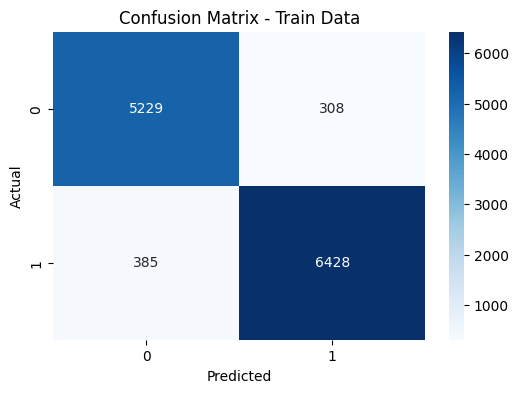

Classification Report - Train Data:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5537
           1       0.95      0.94      0.95      6813

    accuracy                           0.94     12350
   macro avg       0.94      0.94      0.94     12350
weighted avg       0.94      0.94      0.94     12350



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=105, random_state=42,class_weight={0: 1.0, 1: 3}) #3 best now
rf_model.fit(XX_train, yy_train)  # Train on the training data

# Step 3: Predict on test data (the unseen test set)
y_test_pred = rf_model.predict(XX_test)

# Step 4: Calculate accuracy
accuracy = accuracy_score(yy_test, y_test_pred)
print(f"Accuracy on the Test Set: {accuracy:.4f}")

# Confusion matrix for the test data
cm_test = confusion_matrix(yy_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report for the test data
print("Classification Report - Train Data:")
print(classification_report(yy_test, y_test_pred))


**Testing random forest**

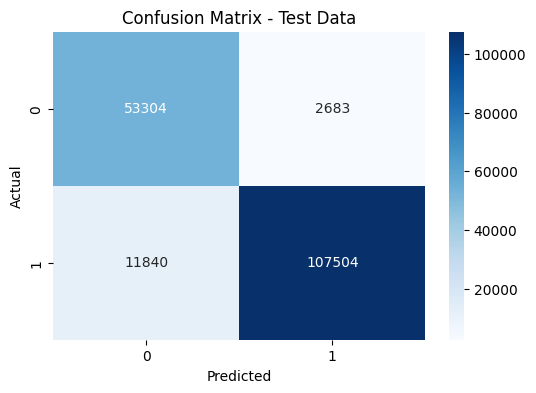

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     55987
           1       0.98      0.90      0.94    119344

    accuracy                           0.92    175331
   macro avg       0.90      0.93      0.91    175331
weighted avg       0.93      0.92      0.92    175331

Accuracy on the Test Dataset: 0.9172


In [ ]:
y_test_pred = rf_model.predict(X_test_selected)

# Step 3: Confusion matrix for the test dataset
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 4: Classification report for the test dataset
print("Classification Report - Test Data:")
print(classification_report(y_test, y_test_pred))
# Step 5: Accuracy on the test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the Test Dataset: {test_accuracy:.4f}")